In [16]:
# 1. ====================== CONFIGURAÇÕES INICIAIS ======================
# Bibliotecas necessárias (sem pmdarima)
!pip install pandas numpy statsmodels scikit-learn scipy joblib gdown matplotlib seaborn tqdm --upgrade

import os
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox
import warnings
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configurações de saída
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')


In [17]:
# 2. ====================== CARREGAMENTO DE DADOS ======================

# IDs dos arquivos Brasil
brasil = ["1jrBtlb1gMlHk8fH8m2l7B8TXuJU4NUn6",
          "1EPNjLOUIZ_EysDRyNN2DY4fUgQgV4lxg",
          "1vklnFIR4j99w_YXLjIAdurh6WRYm-OKI"]

# Dicionário para armazenar os DataFrames
dataframes_brasil = {}

# Baixar e carregar arquivos Brasil
for i, file_id in enumerate(brasil):
    url = f"https://drive.google.com/uc?id={file_id}"
    output = f"arquivo_brasil_{i+1}.parquet"
    gdown.download(url, output, quiet=False)
    dataframes_brasil[f"brasil_{i+1}"] = pd.read_parquet(output)
    print(f"Arquivo Brasil {i+1} baixado e carregado como DataFrame.")

print("\nDataFrames Brasil:")
for name, df in dataframes_brasil.items():
    print(f"{name}: {df.shape}")

# Combinar os DataFrames
df_male = dataframes_brasil['brasil_1']
df_female = dataframes_brasil['brasil_2']
df_both = dataframes_brasil['brasil_3']

df_male['Sexo'] = 'Masculino'
df_female['Sexo'] = 'Feminino'
df_both['Sexo'] = 'Ambos'

df = pd.concat([df_male, df_female, df_both], ignore_index=True)
df

Downloading...
From: https://drive.google.com/uc?id=1jrBtlb1gMlHk8fH8m2l7B8TXuJU4NUn6
To: /content/arquivo_brasil_1.parquet
100%|██████████| 1.18M/1.18M [00:00<00:00, 28.6MB/s]


Arquivo Brasil 1 baixado e carregado como DataFrame.


Downloading...
From: https://drive.google.com/uc?id=1EPNjLOUIZ_EysDRyNN2DY4fUgQgV4lxg
To: /content/arquivo_brasil_2.parquet
100%|██████████| 1.16M/1.16M [00:00<00:00, 47.3MB/s]


Arquivo Brasil 2 baixado e carregado como DataFrame.


Downloading...
From: https://drive.google.com/uc?id=1vklnFIR4j99w_YXLjIAdurh6WRYm-OKI
To: /content/arquivo_brasil_3.parquet
100%|██████████| 1.17M/1.17M [00:00<00:00, 80.6MB/s]


Arquivo Brasil 3 baixado e carregado como DataFrame.

DataFrames Brasil:
brasil_1: (15840, 11)
brasil_2: (15840, 11)
brasil_3: (15840, 11)


,Ano,Grupo Etário,nMx,nqx,nAx,lx,ndx,nLx,Tx,ex,Local,Sexo
0,2000,0,0.032572,0.031678,0.133575,100000.000000,3167.836304,97255.308361,6.731573e+06,67.315733,Brasil,Masculino
1,2000,1-4,0.001249,0.004983,1.557550,96832.163696,482.492585,386150.190896,6.634318e+06,68.513578,Brasil,Masculino
2,2000,5-9,0.000443,0.002211,2.313050,96349.671112,213.068062,481175.852431,6.248168e+06,64.848875,Brasil,Masculino
3,2000,10-14,0.000535,0.002672,2.807357,96136.603050,256.849868,480119.835306,5.766992e+06,59.987473,Brasil,Masculino
4,2000,15-19,0.001947,0.009692,2.856376,95879.753181,929.282967,477406.732610,5.286872e+06,55.140652,Brasil,Masculino
...,...,...,...,...,...,...,...,...,...,...,...,...
47515,2023,70-74,0.019475,0.093117,2.652911,79875.987806,7437.830972,381922.688605,1.318010e+06,16.500708,Distrito Federal,Ambos
47516,2023,75-79,0.033741,0.156369,2.661987,72438.156834,11327.072288,335707.943738,9.360877e+05,12.922577,Distrito Federal,Ambos
47517,2023,80-84,0.059386,0.259972,2.606075,61111.084546,15887.178735,267522.705744,6.003797e+05,9.824400,Distrito Federal,Ambos
47518,2023,85-89,0.101670,0.405819,2.514980,45223.905811,18352.708090,180512.684914,3.328570e+05,7.360201,Distrito Federal,Ambos


In [18]:
# Filtrar apenas Brasil
df = df[df['Local'] == 'Brasil']
df

,Ano,Grupo Etário,nMx,nqx,nAx,lx,ndx,nLx,Tx,ex,Local,Sexo
0,2000,0,0.032572,0.031678,0.133575,100000.000000,3167.836304,97255.308361,6.731573e+06,67.315733,Brasil,Masculino
1,2000,1-4,0.001249,0.004983,1.557550,96832.163696,482.492585,386150.190896,6.634318e+06,68.513578,Brasil,Masculino
2,2000,5-9,0.000443,0.002211,2.313050,96349.671112,213.068062,481175.852431,6.248168e+06,64.848875,Brasil,Masculino
3,2000,10-14,0.000535,0.002672,2.807357,96136.603050,256.849868,480119.835306,5.766992e+06,59.987473,Brasil,Masculino
4,2000,15-19,0.001947,0.009692,2.856376,95879.753181,929.282967,477406.732610,5.286872e+06,55.140652,Brasil,Masculino
...,...,...,...,...,...,...,...,...,...,...,...,...
32155,2023,70-74,0.025080,0.118345,2.622986,73919.273662,8747.989736,348802.272560,1.119783e+06,15.148735,Brasil,Ambos
32156,2023,75-79,0.041087,0.187162,2.623411,65171.283926,12197.555489,296867.838720,7.709812e+05,11.830075,Brasil,Ambos
32157,2023,80-84,0.068396,0.293355,2.576461,52973.728437,15540.107372,227206.579873,4.741134e+05,8.949972,Brasil,Ambos
32158,2023,85-89,0.117528,0.453296,2.478278,37433.621065,16968.515926,144378.220125,2.469068e+05,6.595856,Brasil,Ambos


In [19]:
# 3. ====================== FUNÇÃO DE TRANSFORMAÇÃO INVERSA ======================
def inv_boxcox(y, lmbda):
    """Transformação inversa de Box-Cox implementada manualmente"""
    if lmbda == 0:
        return np.exp(y)
    else:
        return (lmbda * y + 1) ** (1 / lmbda)

# 4. ====================== FUNÇÕES AUXILIARES ======================
def smape(actual, predicted):
    """Calcula o sMAPE simétrico corrigido"""
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted))
    return 200 * np.mean(np.where(denominator != 0,
                                 np.abs(predicted - actual) / denominator,
                                 0))

def find_best_arima(train_data):
    """Busca manual dos melhores parâmetros ARIMA"""
    best_aic = float("inf")
    best_order = (0, 0, 0)

    # Valores possíveis para p, d, q
    p_values = range(0, 3)  # 0,1,2
    d_values = range(0, 2)  # 0,1
    q_values = range(0, 3)  # 0,1,2

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = order
                except:
                    continue

    return best_order

def calculate_weights_rmse(train_series, val_series):
    """Calcula pesos usando RMSE na validação cruzada rolante"""
    arima_errors, ets_errors = [], []
    current_train = train_series.copy()

    for i in range(len(val_series)):
        # Treinar e prever com ARIMA
        try:
            arima_order = find_best_arima(current_train)
            arima_model = ARIMA(current_train, order=arima_order)
            arima_fit = arima_model.fit()
            arima_pred = arima_fit.forecast(steps=1)[0]
            arima_errors.append((arima_pred - val_series.iloc[i])**2)
        except Exception as e:
            arima_errors.append(np.nan)
            print(f"Erro ARIMA: {str(e)}")

        # Treinar e prever com ETS
        try:
            ets_model = ExponentialSmoothing(current_train,
                                            trend='add',
                                            seasonal=None,
                                            damped_trend=True)
            ets_fit = ets_model.fit()
            ets_pred = ets_fit.forecast(steps=1)[0]
            ets_errors.append((ets_pred - val_series.iloc[i])**2)
        except Exception as e:
            ets_errors.append(np.nan)
            print(f"Erro ETS: {str(e)}")

        # Atualizar conjunto de treino
        current_train = pd.concat([current_train, val_series.iloc[[i]]])

    # Calcular RMSEs
    arima_rmse = np.sqrt(np.nanmean(arima_errors)) if not np.isnan(arima_errors).all() else 1
    ets_rmse = np.sqrt(np.nanmean(ets_errors)) if not np.isnan(ets_errors).all() else 1

    # Evitar divisão por zero
    arima_rmse = max(arima_rmse, 1e-10)
    ets_rmse = max(ets_rmse, 1e-10)

    # Calcular pesos (inversamente proporcionais ao RMSE)
    total_inverse = 1/arima_rmse + 1/ets_rmse
    arima_weight = (1/arima_rmse) / total_inverse
    ets_weight = (1/ets_rmse) / total_inverse

    return arima_weight, ets_weight

def model_and_forecast(df, grupo_etario, local, sexo, forecast_years=range(2020, 2071)):
    """Modela e prevê a mortalidade para um grupo específico com transformação logarítmica"""
    # Filtrar dados
    data = df[(df['Grupo Etário'] == grupo_etario) &
              (df['Local'] == local) &
              (df['Sexo'] == sexo)]

    # Fallback para dados insuficientes
    if len(data) < 3:
        print(f"⚠️ Dados insuficientes: {local}/{sexo}/{grupo_etario} - {len(data)} registros")
        return create_fallback_forecast(data, forecast_years)

    # Dividir dados
    train = data[data['Ano'].between(2000, 2010)]
    validation = data[data['Ano'].between(2011, 2014)]
    test = data[data['Ano'].between(2015, 2019)]

    # Verificar dados mínimos
    if len(train) < 2:
        print(f"⚠️ Treino insuficiente: {local}/{sexo}/{grupo_etario} - {len(train)} registros")
        return create_fallback_forecast(data, forecast_years)

    # Preparar séries
    train_series = train.set_index('Ano')['nMx']
    val_series = validation.set_index('Ano')['nMx'] if not validation.empty else pd.Series()
    test_series = test.set_index('Ano')['nMx'] if not test.empty else pd.Series()

    # Verificar se a série é constante
    if train_series.nunique() == 1:
        print(f"⚠️ Série constante: {local}/{sexo}/{grupo_etario}")
        return create_fallback_forecast(data, forecast_years)

    # Offset para evitar log(0)
    offset = 1e-9

    # Transformação logarítmica
    train_series_log = np.log(train_series + offset)
    full_train_series = pd.concat([train_series, val_series])
    full_train_series_log = np.log(full_train_series + offset)

    # Calcular pesos usando validação cruzada na escala log
    try:
        if not val_series.empty:
            val_series_log = np.log(val_series + offset)
            arima_weight, ets_weight = calculate_weights_rmse(train_series_log, val_series_log)
        else:
            arima_weight, ets_weight = 0.5, 0.5
    except Exception as e:
        print(f"⚠️ Erro cálculo pesos: {local}/{sexo}/{grupo_etario} - {str(e)}")
        arima_weight, ets_weight = 0.5, 0.5

    # Modelo ARIMA (escala log)
    try:
        arima_order = find_best_arima(full_train_series_log)
        arima_model = ARIMA(full_train_series_log, order=arima_order)
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.get_forecast(steps=len(forecast_years))
        arima_pred_log = arima_forecast.predicted_mean
        arima_conf_log = arima_forecast.conf_int(alpha=0.05)
    except Exception as e:
        print(f"⚠️ Erro ARIMA: {local}/{sexo}/{grupo_etario} - {str(e)}")
        arima_pred_log = np.full(len(forecast_years), full_train_series_log.mean())
        arima_conf_log = pd.DataFrame({
            'lower': arima_pred_log - 0.1,
            'upper': arima_pred_log + 0.1
        }, index=forecast_years)

    # Modelo ETS (escala log)
    try:
        ets_model = ExponentialSmoothing(full_train_series_log,
                                        trend='add',
                                        seasonal=None,
                                        damped_trend=True)
        ets_fit = ets_model.fit()
        ets_pred_log = ets_fit.forecast(steps=len(forecast_years))
    except Exception as e:
        print(f"⚠️ Erro ETS: {local}/{sexo}/{grupo_etario} - {str(e)}")
        ets_pred_log = np.full(len(forecast_years), full_train_series_log.mean())

    # Combinação de modelos na escala log
    combined_pred_log = arima_weight * arima_pred_log + ets_weight * ets_pred_log

    # Calcular variância dos resíduos para correção de viés
    try:
        resid = arima_fit.resid
        resid_var = np.var(resid)
    except:
        resid_var = 0

    # Retransformar com correção de viés (método de Duan)
    combined_pred = np.exp(combined_pred_log - 0.5 * resid_var) - offset
    combined_conf_lower = np.exp(arima_conf_log.iloc[:, 0] - 0.5 * resid_var) - offset
    combined_conf_upper = np.exp(arima_conf_log.iloc[:, 1] - 0.5 * resid_var) - offset

    # Calcular métricas no conjunto de teste (se disponível)
    metrics = {'MSE': np.nan, 'MAE': np.nan, 'sMAPE': np.nan}
    if not test_series.empty and len(test_series) > 0:
        try:
            test_steps = len(test_series)
            # Previsões na escala log para o período de teste
            arima_pred_test_log = arima_fit.forecast(steps=test_steps)
            ets_pred_test_log = ets_fit.forecast(steps=test_steps)
            combined_pred_test_log = arima_weight * arima_pred_test_log + ets_weight * ets_pred_test_log

            # Retransformar
            combined_pred_test = np.exp(combined_pred_test_log - 0.5 * resid_var) - offset

            # Calcular métricas
            metrics['MSE'] = mean_squared_error(test_series, combined_pred_test)
            metrics['MAE'] = mean_absolute_error(test_series, combined_pred_test)
            metrics['sMAPE'] = smape(test_series, combined_pred_test)
        except Exception as e:
            print(f"⚠️ Erro cálculo métricas: {local}/{sexo}/{grupo_etario} - {str(e)}")

    # DataFrame de previsões
    forecast_df = pd.DataFrame({
        'Ano': list(forecast_years),
        'Previsao': combined_pred.values,
        'IC_inferior': combined_conf_lower.values,
        'IC_superior': combined_conf_upper.values
    })

    return metrics, forecast_df

def process_group(args, all_forecasts, all_metrics):
    """Função para processar cada grupo e acumular resultados"""
    local, sex, age_group, df = args
    print(f"Processando: {local}, {sex}, {age_group}")

    try:
        metrics, forecast_df = model_and_forecast(df, age_group, local, sex)
        if metrics is not None and forecast_df is not None:
            # Adicionar identificadores
            forecast_df['Local'] = local
            forecast_df['Sexo'] = sex
            forecast_df['Grupo Etário'] = age_group

            # Adicionar resultados às listas
            all_forecasts.append(forecast_df)

            # Adicionar métricas
            metrics_record = {
                'Local': local,
                'Sexo': sex,
                'Grupo Etário': age_group,
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'sMAPE': metrics['sMAPE']
            }
            all_metrics.append(metrics_record)

        return True
    except Exception as e:
        print(f"Erro crítico em {local}, {sex}, {age_group}: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

def save_final_results(all_forecasts, all_metrics):
    """Salva os arquivos consolidados por local/sexo no formato solicitado"""
    # Juntar todas as previsões
    forecasts_df = pd.concat(all_forecasts, ignore_index=True)

    # Juntar todas as métricas
    metrics_df = pd.DataFrame(all_metrics)

    # Adicionar RMSE (raiz do erro quadrático médio)
    metrics_df['RMSE'] = np.sqrt(metrics_df['MSE'])

    # Ordem dos grupos etários (baseado nos dados)
    age_order = [
        '0', '1-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
        '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
        '80-84', '85-89', '90+'
    ]

    # Salvar arquivos por combinação local/sexo
    for (location, sex), group in forecasts_df.groupby(['Local', 'Sexo']):
        # Sanitizar nomes
        safe_location = location.replace("/", "_").replace(" ", "_")
        safe_sex = sex.replace("/", "_").replace(" ", "_")

        # Ordenar por ano e grupo etário
        group['Grupo Etário'] = pd.Categorical(
            group['Grupo Etário'],
            categories=age_order,
            ordered=True
        )
        group = group.sort_values(['Ano', 'Grupo Etário'])

        # Selecionar e renomear colunas
        group = group[[
            'Local', 'Sexo', 'Ano', 'Grupo Etário',
            'Previsao', 'IC_inferior', 'IC_superior'
        ]].rename(columns={
            'Previsao': 'Previsão',
            'IC_inferior': 'Limite Inferior',
            'IC_superior': 'Limite Superior'
        })

        # Salvar previsões
        forecast_path = f"Downloads/forecasts/previsao_{safe_location}_{safe_sex}.csv"
        group.to_csv(forecast_path, index=False)
        print(f"Salvo: {forecast_path}")

    for (location, sex), group in metrics_df.groupby(['Local', 'Sexo']):
        # Sanitizar nomes
        safe_location = location.replace("/", "_").replace(" ", "_")
        safe_sex = sex.replace("/", "_").replace(" ", "_")

        # Ordenar por grupo etário
        group['Grupo Etário'] = pd.Categorical(
            group['Grupo Etário'],
            categories=age_order,
            ordered=True
        )
        group = group.sort_values('Grupo Etário')

        # Selecionar colunas
        group = group[[
            'Local', 'Sexo', 'Grupo Etário',
            'RMSE', 'sMAPE', 'MAE'
        ]]

        # Salvar métricas
        metrics_path = f"Downloads/metrics/erros_{safe_location}_{safe_sex}.csv"
        group.to_csv(metrics_path, index=False)
        print(f"Salvo: {metrics_path}")

In [20]:
# 5. ====================== PROCESSAMENTO PRINCIPAL ======================
# Configurar pastas de saída
os.makedirs("Downloads/forecasts", exist_ok=True)
os.makedirs("Downloads/metrics", exist_ok=True)

# Lista de locais e grupos etários
locais = df['Local'].unique()
sexos = df['Sexo'].unique()
grupos_etarios = df['Grupo Etário'].unique()

print(f"\nIniciando processamento para {len(locais)} locais, {len(sexos)} sexos, {len(grupos_etarios)} grupos etários")
print(f"Total de combinações: {len(locais)*len(sexos)*len(grupos_etarios)}")

# Listas para acumular resultados
all_forecasts = []
all_metrics = []

# Criar lista de tarefas
args_list = [(local, sex, age_group, df)
             for local in locais
             for sex in sexos
             for age_group in grupos_etarios]

# Processar grupos (com barra de progresso)
for args in tqdm(args_list, desc="Processando grupos"):
    process_group(args, all_forecasts, all_metrics)

# Salvar resultados no formato solicitado
save_final_results(all_forecasts, all_metrics)

print("\nProcesso completo! Arquivos gerados:")
print(f"- Previsões: {len(locais) * len(sexos)} arquivos em Downloads/forecasts/")
print(f"- Métricas: {len(locais) * len(sexos)} arquivos em Downloads/metrics/")
print(f"Total de arquivos: {2 * len(locais) * len(sexos)}")


Iniciando processamento para 1 locais, 3 sexos, 20 grupos etários
Total de combinações: 60


Processando grupos:   0%|          | 0/60 [00:00<?, ?it/s]

Processando: Brasil, Masculino, 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:   2%|▏         | 1/60 [00:38<38:02, 38.69s/it]

Processando: Brasil, Masculino, 1-4
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:   3%|▎         | 2/60 [00:58<26:40, 27.59s/it]

Processando: Brasil, Masculino, 5-9
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:   5%|▌         | 3/60 [01:16<22:01, 23.18s/it]

Processando: Brasil, Masculino, 10-14
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:   7%|▋         | 4/60 [01:35<20:01, 21.46s/it]

Processando: Brasil, Masculino, 15-19
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:   8%|▊         | 5/60 [01:52<18:13, 19.89s/it]

Processando: Brasil, Masculino, 20-24
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  10%|█         | 6/60 [02:11<17:48, 19.79s/it]

Processando: Brasil, Masculino, 25-29
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  12%|█▏        | 7/60 [02:28<16:37, 18.82s/it]

Processando: Brasil, Masculino, 30-34
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  13%|█▎        | 8/60 [02:46<16:03, 18.54s/it]

Processando: Brasil, Masculino, 35-39
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  15%|█▌        | 9/60 [03:04<15:31, 18.26s/it]

Processando: Brasil, Masculino, 40-44
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  17%|█▋        | 10/60 [03:20<14:41, 17.63s/it]

Processando: Brasil, Masculino, 45-49
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  18%|█▊        | 11/60 [03:36<13:59, 17.13s/it]

Processando: Brasil, Masculino, 50-54
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  20%|██        | 12/60 [03:57<14:34, 18.21s/it]

Processando: Brasil, Masculino, 55-59
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  22%|██▏       | 13/60 [04:14<14:05, 18.00s/it]

Processando: Brasil, Masculino, 60-64
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  23%|██▎       | 14/60 [04:30<13:15, 17.30s/it]

Processando: Brasil, Masculino, 65-69
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  25%|██▌       | 15/60 [04:50<13:29, 17.99s/it]

Processando: Brasil, Masculino, 70-74
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  27%|██▋       | 16/60 [05:08<13:24, 18.28s/it]

Processando: Brasil, Masculino, 75-79
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  28%|██▊       | 17/60 [05:33<14:24, 20.12s/it]

Processando: Brasil, Masculino, 80-84
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  30%|███       | 18/60 [05:58<15:12, 21.73s/it]

Processando: Brasil, Masculino, 85-89
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  32%|███▏      | 19/60 [06:19<14:41, 21.50s/it]

Processando: Brasil, Masculino, 90+
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  33%|███▎      | 20/60 [06:38<13:51, 20.79s/it]

Processando: Brasil, Feminino, 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  35%|███▌      | 21/60 [07:01<13:45, 21.17s/it]

Processando: Brasil, Feminino, 1-4
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  37%|███▋      | 22/60 [07:26<14:12, 22.43s/it]

Processando: Brasil, Feminino, 5-9
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  38%|███▊      | 23/60 [07:49<13:58, 22.66s/it]

Processando: Brasil, Feminino, 10-14
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  40%|████      | 24/60 [08:10<13:18, 22.19s/it]

Processando: Brasil, Feminino, 15-19
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  42%|████▏     | 25/60 [08:35<13:22, 22.93s/it]

Processando: Brasil, Feminino, 20-24
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  43%|████▎     | 26/60 [08:58<13:02, 23.02s/it]

Processando: Brasil, Feminino, 25-29
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  45%|████▌     | 27/60 [09:24<13:05, 23.80s/it]

Processando: Brasil, Feminino, 30-34
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  47%|████▋     | 28/60 [09:51<13:15, 24.87s/it]

Processando: Brasil, Feminino, 35-39
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  48%|████▊     | 29/60 [10:15<12:42, 24.59s/it]

Processando: Brasil, Feminino, 40-44
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  50%|█████     | 30/60 [10:41<12:26, 24.88s/it]

Processando: Brasil, Feminino, 45-49
Erro ARIMA: 0
Erro ETS: 0


/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:660: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  retvals = optimize.fmin_l_bfgs_b(func, start_params, maxiter=maxiter,


Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  52%|█████▏    | 31/60 [11:03<11:44, 24.28s/it]

Processando: Brasil, Feminino, 50-54
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  53%|█████▎    | 32/60 [11:24<10:49, 23.18s/it]

Processando: Brasil, Feminino, 55-59
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  55%|█████▌    | 33/60 [11:48<10:29, 23.32s/it]

Processando: Brasil, Feminino, 60-64
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  57%|█████▋    | 34/60 [12:12<10:13, 23.61s/it]

Processando: Brasil, Feminino, 65-69
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  58%|█████▊    | 35/60 [12:33<09:33, 22.93s/it]

Processando: Brasil, Feminino, 70-74
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  60%|██████    | 36/60 [12:51<08:34, 21.42s/it]

Processando: Brasil, Feminino, 75-79
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  62%|██████▏   | 37/60 [13:14<08:22, 21.85s/it]

Processando: Brasil, Feminino, 80-84
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  63%|██████▎   | 38/60 [13:40<08:26, 23.01s/it]

Processando: Brasil, Feminino, 85-89
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  65%|██████▌   | 39/60 [14:02<07:55, 22.63s/it]

Processando: Brasil, Feminino, 90+
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  67%|██████▋   | 40/60 [14:18<06:56, 20.84s/it]

Processando: Brasil, Ambos, 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  68%|██████▊   | 41/60 [14:39<06:37, 20.93s/it]

Processando: Brasil, Ambos, 1-4
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  70%|███████   | 42/60 [15:10<07:07, 23.76s/it]

Processando: Brasil, Ambos, 5-9
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  72%|███████▏  | 43/60 [15:33<06:42, 23.69s/it]

Processando: Brasil, Ambos, 10-14
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  73%|███████▎  | 44/60 [15:54<06:04, 22.80s/it]

Processando: Brasil, Ambos, 15-19


/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:660: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  retvals = optimize.fmin_l_bfgs_b(func, start_params, maxiter=maxiter,


Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  75%|███████▌  | 45/60 [16:18<05:45, 23.06s/it]

Processando: Brasil, Ambos, 20-24
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  77%|███████▋  | 46/60 [16:39<05:16, 22.61s/it]

Processando: Brasil, Ambos, 25-29
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  78%|███████▊  | 47/60 [17:02<04:54, 22.68s/it]

Processando: Brasil, Ambos, 30-34
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  80%|████████  | 48/60 [17:23<04:26, 22.18s/it]

Processando: Brasil, Ambos, 35-39
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  82%|████████▏ | 49/60 [17:46<04:07, 22.51s/it]

Processando: Brasil, Ambos, 40-44
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  83%|████████▎ | 50/60 [18:09<03:45, 22.53s/it]

Processando: Brasil, Ambos, 45-49
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  85%|████████▌ | 51/60 [18:30<03:17, 21.98s/it]

Processando: Brasil, Ambos, 50-54
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  87%|████████▋ | 52/60 [18:51<02:53, 21.72s/it]

Processando: Brasil, Ambos, 55-59
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  88%|████████▊ | 53/60 [19:14<02:35, 22.24s/it]

Processando: Brasil, Ambos, 60-64
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  90%|█████████ | 54/60 [19:34<02:09, 21.60s/it]

Processando: Brasil, Ambos, 65-69
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  92%|█████████▏| 55/60 [19:55<01:46, 21.27s/it]

Processando: Brasil, Ambos, 70-74
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  93%|█████████▎| 56/60 [20:15<01:23, 20.96s/it]

Processando: Brasil, Ambos, 75-79
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  95%|█████████▌| 57/60 [20:39<01:05, 21.84s/it]

Processando: Brasil, Ambos, 80-84
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  97%|█████████▋| 58/60 [21:06<00:46, 23.43s/it]

Processando: Brasil, Ambos, 85-89
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos:  98%|█████████▊| 59/60 [21:26<00:22, 22.26s/it]

Processando: Brasil, Ambos, 90+
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0
Erro ARIMA: 0
Erro ETS: 0


Processando grupos: 100%|██████████| 60/60 [21:45<00:00, 21.76s/it]


Salvo: Downloads/forecasts/previsao_Brasil_Ambos.csv
Salvo: Downloads/forecasts/previsao_Brasil_Feminino.csv
Salvo: Downloads/forecasts/previsao_Brasil_Masculino.csv
Salvo: Downloads/metrics/erros_Brasil_Ambos.csv
Salvo: Downloads/metrics/erros_Brasil_Feminino.csv
Salvo: Downloads/metrics/erros_Brasil_Masculino.csv

Processo completo! Arquivos gerados:
- Previsões: 3 arquivos em Downloads/forecasts/
- Métricas: 3 arquivos em Downloads/metrics/
Total de arquivos: 6


In [21]:
# carregar previsões de homens
df_male = pd.read_csv("Downloads/forecasts/previsao_Brasil_Masculino.csv")
df_male

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.010108,0.009720,0.010576
1,Brasil,Masculino,2020,1-4,0.000136,0.000133,0.000139
2,Brasil,Masculino,2020,5-9,0.000042,0.000041,0.000043
3,Brasil,Masculino,2020,10-14,0.000069,0.000066,0.000070
4,Brasil,Masculino,2020,15-19,0.002116,0.002052,0.002120
...,...,...,...,...,...,...,...
1015,Brasil,Masculino,2070,70-74,0.019507,0.012399,0.049528
1016,Brasil,Masculino,2070,75-79,0.044565,0.053257,0.068929
1017,Brasil,Masculino,2070,80-84,0.057468,0.044034,0.115672
1018,Brasil,Masculino,2070,85-89,0.131964,0.135429,0.148300


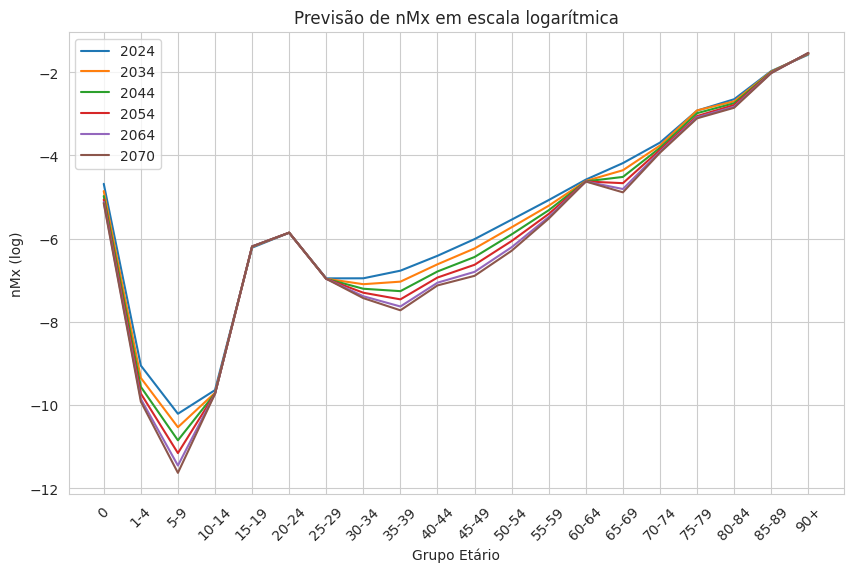

In [37]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_male[df_male['Ano'] == 2024], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_male[df_male['Ano'] == 2034], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_male[df_male['Ano'] == 2044], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_male[df_male['Ano'] == 2054], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_male[df_male['Ano'] == 2064], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_male[df_male['Ano'] == 2070], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [24]:
# Carregar métricas de erros
df_metrics_male = pd.read_csv("Downloads/metrics/erros_Brasil_Masculino.csv")
df_metrics_male

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Masculino,0,0.003993,34.306815,0.003988
1,Brasil,Masculino,1-4,0.000428,125.850150,0.000428
2,Brasil,Masculino,5-9,0.000213,146.162366,0.000213
3,Brasil,Masculino,10-14,0.000299,138.089921,0.000299
4,Brasil,Masculino,15-19,0.000158,6.167229,0.000119
5,Brasil,Masculino,20-24,0.000170,4.336541,0.000118
6,Brasil,Masculino,25-29,0.001622,91.278046,0.001617
7,Brasil,Masculino,30-34,0.001630,89.914245,0.001628
8,Brasil,Masculino,35-39,0.001801,85.115537,0.001799
9,Brasil,Masculino,40-44,0.002129,76.536105,0.002126


In [25]:
# Carregar previsões femininas
df_female = pd.read_csv("Downloads/forecasts/previsao_Brasil_Feminino.csv")
df_female

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.007832,0.007523,0.008170
1,Brasil,Feminino,2020,1-4,0.000113,0.000110,0.000116
2,Brasil,Feminino,2020,5-9,0.000027,0.000026,0.000028
3,Brasil,Feminino,2020,10-14,0.000034,0.000034,0.000035
4,Brasil,Feminino,2020,15-19,0.000085,0.000083,0.000087
...,...,...,...,...,...,...,...
1015,Brasil,Feminino,2070,70-74,0.010982,0.003845,0.027407
1016,Brasil,Feminino,2070,75-79,0.020730,0.012868,0.053212
1017,Brasil,Feminino,2070,80-84,0.047648,0.018001,0.130171
1018,Brasil,Feminino,2070,85-89,0.112075,0.110579,0.124918


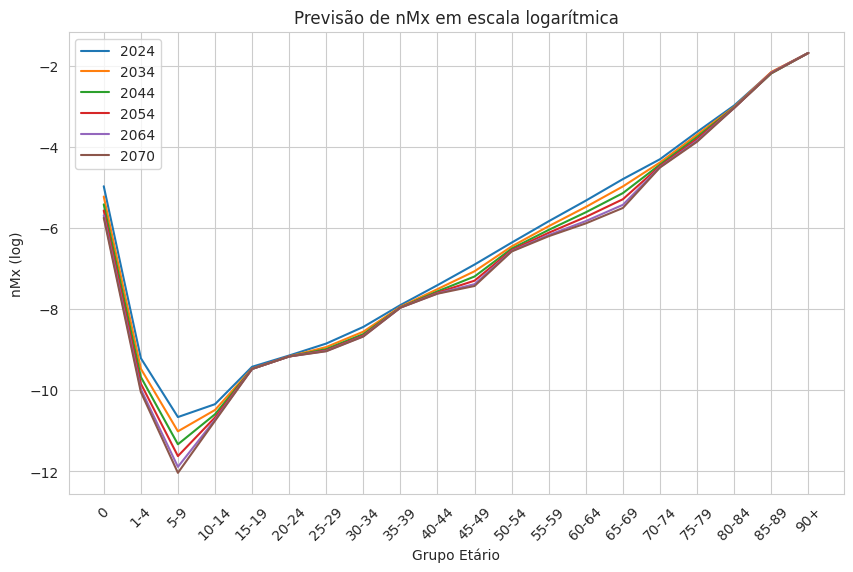

In [36]:
# Plotar gráfico em log para os anos de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_female[df_female['Ano'] == 2024], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_female[df_female['Ano'] == 2034], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_female[df_female['Ano'] == 2044], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_female[df_female['Ano'] == 2054], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_female[df_female['Ano'] == 2064], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_female[df_female['Ano'] == 2070], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [28]:
# Carregar métricas de erros
df_metrics_female = pd.read_csv("Downloads/metrics/erros_Brasil_Feminino.csv")
df_metrics_female

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Feminino,0,0.004152,43.953797,0.004139
1,Brasil,Feminino,1-4,0.000374,127.723902,0.000374
2,Brasil,Feminino,5-9,0.000176,155.603728,0.000176
3,Brasil,Feminino,10-14,0.000210,152.078070,0.000210
4,Brasil,Feminino,15-19,0.000373,138.578777,0.000373
5,Brasil,Feminino,20-24,0.000453,135.295276,0.000453
6,Brasil,Feminino,25-29,0.000516,127.560968,0.000516
7,Brasil,Feminino,30-34,0.000667,119.771153,0.000667
8,Brasil,Feminino,35-39,0.000896,108.856916,0.000895
9,Brasil,Feminino,40-44,0.001226,99.396464,0.001226


In [29]:
# Carregar dados do sexo ambos
df_both = pd.read_csv("Downloads/forecasts/previsao_Brasil_Ambos.csv")
df_both

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Ambos,2020,0,0.013466,0.013385,0.014055
1,Brasil,Ambos,2020,1-4,0.000124,0.000121,0.000127
2,Brasil,Ambos,2020,5-9,0.000034,0.000033,0.000035
3,Brasil,Ambos,2020,10-14,0.000051,0.000050,0.000052
4,Brasil,Ambos,2020,15-19,0.001305,0.001276,0.001307
...,...,...,...,...,...,...,...
1015,Brasil,Ambos,2070,70-74,0.016500,0.009822,0.035613
1016,Brasil,Ambos,2070,75-79,0.025024,0.016980,0.059979
1017,Brasil,Ambos,2070,80-84,0.052805,0.028145,0.118494
1018,Brasil,Ambos,2070,85-89,0.114216,0.119150,0.136573


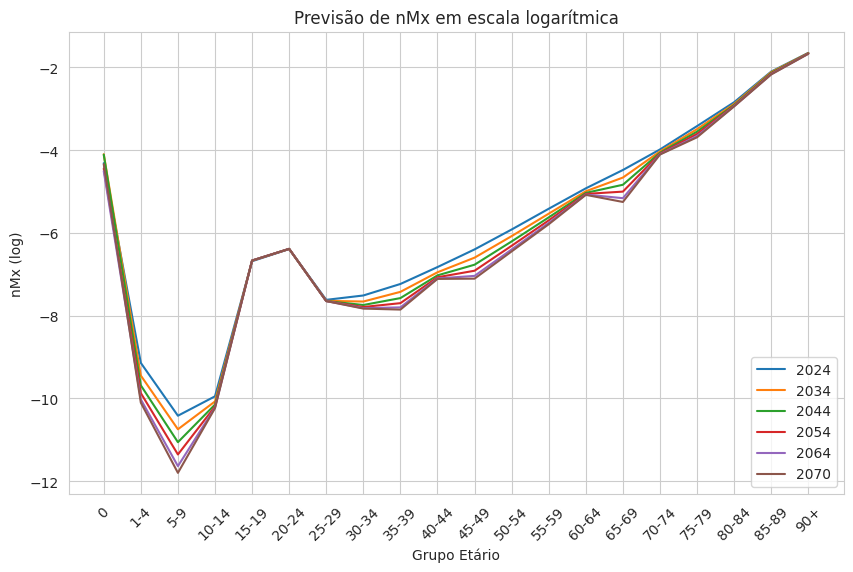

In [34]:
# Plotar gráfico em log 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_both[df_both['Ano'] == 2024], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_both[df_both['Ano'] == 2034], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_both[df_both['Ano'] == 2044], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_both[df_both['Ano'] == 2054], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_both[df_both['Ano'] == 2064], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_both[df_both['Ano'] == 2070], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [31]:
# Carregar métricas de erros
df_metrics_both = pd.read_csv("Downloads/metrics/erros_Brasil_Ambos.csv")
df_metrics_both

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Ambos,0,0.000810,5.918389,0.000765
1,Brasil,Ambos,1-4,0.000403,127.130178,0.000403
2,Brasil,Ambos,5-9,0.000195,150.491255,0.000195
3,Brasil,Ambos,10-14,0.000256,144.195950,0.000256
4,Brasil,Ambos,15-19,0.000092,5.369506,0.000064
5,Brasil,Ambos,20-24,0.000075,3.506677,0.000058
6,Brasil,Ambos,25-29,0.001113,105.109846,0.001111
7,Brasil,Ambos,30-34,0.001174,101.336083,0.001173
8,Brasil,Ambos,35-39,0.001365,94.809242,0.001364
9,Brasil,Ambos,40-44,0.001688,85.589901,0.001686
